<a href="https://colab.research.google.com/github/NehaSontakk/BATH-Prokka-Comparison/blob/main/Updated_Contig_comparison_identifying_gaps_Prokka_vs_BATH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install gffpandas
!sudo apt-get install bedops
!pip install biopython

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
bedops is already the newest version (2.4.40+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import subprocess
import matplotlib.pyplot as plt
import gffpandas.gffpandas as gffpd
from Bio import SeqIO
from glob import glob
from pathlib import Path

In [13]:
annotation = gffpd.read_gff3('/content/drive/MyDrive/Lab Work/Parkinsons_Data/Examples/bin82/bin_82_prokka_annotation.gff')
combined_df = annotation.filter_feature_of_type(['CDS'])
attr_to_columns = combined_df.attributes_to_columns()
prokka_proteins = pd.DataFrame(attr_to_columns)
prokka_proteins['start'] = prokka_proteins['start'].astype(int)
prokka_proteins['end'] = prokka_proteins['end'].astype(int)

In [14]:
prokka_proteins.head()

,seq_id,source,type,start,end,score,strand,phase,attributes,ID,Name,db_xref,eC_number,gene,inference,locus_tag,note,product
0,k127_1013475,Prodigal:002006,CDS,28,825,.,+,0,ID=CKDIDOFJ_00001;eC_number=7.1.1.-;Name=ndhH;...,CKDIDOFJ_00001,ndhH,COG:COG0649,7.1.1.-,ndhH,"ab initio prediction:Prodigal:002006,similar t...",CKDIDOFJ_00001,None,NAD(P)H-quinone oxidoreductase subunit H
1,k127_1013475,Prodigal:002006,CDS,904,2010,.,+,0,ID=CKDIDOFJ_00002;eC_number=7.1.1.-;Name=nuoH;...,CKDIDOFJ_00002,nuoH,COG:COG1005,7.1.1.-,nuoH,"ab initio prediction:Prodigal:002006,similar t...",CKDIDOFJ_00002,None,NADH-quinone oxidoreductase subunit H
2,k127_1013475,Prodigal:002006,CDS,2108,3613,.,+,0,ID=CKDIDOFJ_00003;eC_number=7.1.2.2;Name=atpD;...,CKDIDOFJ_00003,atpD,COG:COG0055,7.1.2.2,atpD,"ab initio prediction:Prodigal:002006,similar t...",CKDIDOFJ_00003,None,ATP synthase subunit beta
3,k127_1013475,Prodigal:002006,CDS,3678,3914,.,+,0,ID=CKDIDOFJ_00004;Name=atpC;gene=atpC;inferenc...,CKDIDOFJ_00004,atpC,None,None,atpC,"ab initio prediction:Prodigal:002006,protein m...",CKDIDOFJ_00004,None,ATP synthase epsilon chain
4,k127_1013475,Prodigal:002006,CDS,3944,5182,.,+,0,ID=CKDIDOFJ_00005;Name=atpB;gene=atpB;inferenc...,CKDIDOFJ_00005,atpB,None,None,atpB,"ab initio prediction:Prodigal:002006,protein m...",CKDIDOFJ_00005,None,ATP synthase subunit a


In [15]:
bath_protein = pd.read_excel("/content/bin82_BATH_deduplicated-11.xlsx")
unnamed_cols = [col for col in bath_protein.columns if col.startswith('Unnamed')]
bath_protein.drop(columns=unnamed_cols, inplace=True)
bath_protein['start'] = bath_protein['ali from']
bath_protein['end'] = bath_protein['ali to']
bath_protein['start'].fillna(bath_protein['ali from flip'],inplace=True)
bath_protein['end'].fillna(bath_protein['ali to flip'],inplace=True)

In [16]:
bath_protein.head()

,target name,accession,query name,accession1,hmm len,hmm from,hmm to,seq len,ali from,ali to,...,shifts,stops,pipe,description of target,strand,ali from flip,ali to flip,origin,start,end
0,k127_1013475,-,P27724,-,394,96,394,183529,1,822,...,0,0,std,-,+,NaN,NaN,DNA_Archaea_kingdom_sprot,1,822
1,k127_1013475,-,P9WIX1,-,410,4,337,183529,982,1986,...,0,0,std,-,+,NaN,NaN,DNA_Archaea_kingdom_sprot,982,1986
2,k127_1013475,-,Q8DLG8,-,482,10,478,183529,2120,3586,...,0,0,std,-,+,NaN,NaN,DNA_Archaea_kingdom_sprot,2120,3586
3,k127_1013475,-,O05330,-,237,39,237,183529,4448,5059,...,0,0,std,-,+,NaN,NaN,DNA_Archaea_kingdom_sprot,4448,5059
4,k127_1013475,-,Q0ZS22,-,180,4,175,183529,6313,6843,...,0,0,std,-,+,NaN,NaN,DNA_Archaea_kingdom_sprot,6313,6843


## Find the gaps filled by BATH vs Prokka per contig

In [17]:
# Add 'ID' to bath_protein
bath_protein['ID'] = bath_protein['query name']

# Separate BATH data into positive and negative strands
pos_strand = bath_protein[bath_protein['strand'] == "+"].copy()
neg_strand = bath_protein[bath_protein['strand'] == "-"].copy()

# Handle columns for positive strand
pos_strand.loc[:, 'start'] = pos_strand['ali from'].astype(int)
pos_strand.loc[:, 'end'] = pos_strand['ali to'].astype(int)

# Handle columns for negative strand
neg_strand.loc[:, 'start'] = neg_strand['ali from flip'].astype(int)
neg_strand.loc[:, 'end'] = neg_strand['ali to flip'].astype(int)

# Filter Prokka proteins into positive and negative strands
prokka_proteins_plus = prokka_proteins[prokka_proteins['strand'] == '+'].copy()
prokka_proteins_minus = prokka_proteins[prokka_proteins['strand'] == '-'].copy()

# Sort and save positive strand Prokka proteins
prokka_proteins_plus.sort_values('start', inplace=True)
prokka_proteins_plus.to_csv('prokka_proteins_plus.bed', sep='\t', index=False, header=False, columns=['seq_id', 'start', 'end', 'strand', 'ID', 'inference'])

# Sort and save negative strand Prokka proteins
prokka_proteins_minus.sort_values('start', inplace=True)
prokka_proteins_minus.to_csv('prokka_proteins_minus.bed', sep='\t', index=False, header=False, columns=['seq_id', 'start', 'end', 'strand', 'ID', 'inference'])

# Sort and save BATH deduplicated positive strand
bath_deduplicated_plus = pos_strand[['target name', 'start', 'end', 'strand', 'ID', 'shifts']].copy()
bath_deduplicated_plus.sort_values('start', inplace=True)
bath_deduplicated_plus.to_csv('bath_deduplicated_plus.bed', sep='\t', index=False, header=False)

# Sort and save BATH deduplicated negative strand
bath_deduplicated_minus = neg_strand[['target name', 'start', 'end', 'strand', 'ID', 'shifts']].copy()
bath_deduplicated_minus.sort_values('start', inplace=True)
bath_deduplicated_minus.to_csv('bath_deduplicated_minus.bed', sep='\t', index=False, header=False)


In [18]:
def generate_bed_files(df, directory, contig_column, file_prefix='Prokka_annotation'):
    """
    Generates BED files for each unique 'seq_id' in the DataFrame.
    - df: DataFrame to process.
    - directory: Path to the directory where BED files will be saved.
    - contig_column: Name of column with contig names
    - file_prefix: Prefix for the BED files' names. Default is 'Prokka_annotation'.
    """
    os.makedirs(directory, exist_ok=True)
    for seq_id in df[contig_column].unique():
        df_seq = df[df[contig_column] == seq_id]
        print(df_seq.shape)
        df_seq = df[df[contig_column] == seq_id].sort_values(by=['start'])
        filename = f'{directory}/{file_prefix}_{seq_id}.bed'
        with open(filename, 'w') as file:
            for _, row in df_seq.iterrows():
              #For a prokka file
              if file_prefix == "Prokka_annotation":
                bed_line = f"{row[contig_column]}\t{row['start']}\t{row['end']}\t{row['ID']}\t{row['strand']}\t{row['inference']}\n"
                file.write(bed_line)
              else:
                #For a BATH file
                bed_line = f"{row[contig_column]}\t{row['start']}\t{row['end']}\t{row['ID']}\t{row['strand']}\t{row['shifts']}\n"
                file.write(bed_line)

    print(f"BED files have been successfully generated in {directory}")

directory = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Prokka_Annotation_PLUS_BED/'
generate_bed_files(prokka_proteins_plus, directory, 'seq_id',file_prefix='Prokka_annotation')

directory2 = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Prokka_Annotation_MINUS_BED/'
generate_bed_files(prokka_proteins_minus, directory2, 'seq_id',file_prefix='Prokka_annotation')

directory3 = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/BATH_Annotation_PLUS_BED/'
generate_bed_files(bath_deduplicated_plus, directory3, 'target name',file_prefix='BATH_annotation')

directory4 = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/BATH_Annotation_MINUS_BED/'
generate_bed_files(bath_deduplicated_minus, directory4, 'target name',file_prefix='BATH_annotation')

(30, 18)
(68, 18)
(46, 18)
(15, 18)
(62, 18)
(110, 18)
(71, 18)
(7, 18)
(40, 18)
(27, 18)
(4, 18)
(32, 18)
(33, 18)
(15, 18)
(60, 18)
(11, 18)
(66, 18)
(54, 18)
(61, 18)
(60, 18)
(43, 18)
BED files have been successfully generated in /content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Prokka_Annotation_PLUS_BED/
(47, 18)
(25, 18)
(91, 18)
(56, 18)
(55, 18)
(76, 18)
(39, 18)
(18, 18)
(25, 18)
(30, 18)
(73, 18)
(17, 18)
(29, 18)
(112, 18)
(27, 18)
(3, 18)
(16, 18)
(5, 18)
(30, 18)
(42, 18)
(78, 18)
BED files have been successfully generated in /content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Prokka_Annotation_MINUS_BED/
(35, 6)
(46, 6)
(48, 6)
(6, 6)
(32, 6)
(9, 6)
(12, 6)
(22, 6)
(5, 6)
(29, 6)
(32, 6)
(16, 6)
(30, 6)
(23, 6)
(22, 6)
(17, 6)
(31, 6)
(19, 6)
(10, 6)
(9, 6)
BED files have been successfully generated in /content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/BATH_Annotation_PLUS_BED/
(25, 6)
(31, 6)
(34, 6)
(11, 6)
(34, 6)
(12, 6)
(46, 6)
(35, 

In [19]:
'''
def run_bedmap_overlap(bed_file1, bed_file2, output_file):
    """Run bedmap to find overlaps between two BED files and filter out lines with no valid second element after splitting."""
    command = [
        "bedmap", "--echo", "--echo-map", "--delim", ";",
        "--fraction-ref", "0.1",
        bed_file1, bed_file2
    ]
    result = subprocess.run(command, capture_output=True, text=True, check=True)

    with open(output_file, 'w') as f_output:
        for line in result.stdout.splitlines():
            parts = line.split(';')
            if len(parts) > 1 and parts[1].strip():
                f_output.write(line + '\n')

def run_bedmap_unique(bed_file1, bed_file2, output_file, unique_to_first=True):
    """
    Run bedmap to find items unique to the first or second BED file.
    unique_to_first: If True, find items unique to bed_file1; otherwise, find items unique to bed_file2.
    """
    if unique_to_first:
        indicator_command = ["bedmap", "--echo", "--indicator", bed_file1, bed_file2]
    else:
        indicator_command = ["bedmap", "--echo", "--indicator", bed_file2, bed_file1]

    with open(output_file, 'w') as f_output, subprocess.Popen(indicator_command, stdout=subprocess.PIPE, text=True) as proc:
        for line in proc.stdout:
            if line.strip().endswith("0"):
                f_output.write(line.split('|')[0] + '\n')

bed_file1 = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/BATH_Annotation_PLUS_BED/BATH_annotation_k127_39946.bed'
bed_file2 = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Prokka_Annotation_PLUS_BED/Prokka_annotation_k127_39946.bed'
overlap_output = 'overlap_prokka_bath_k127_39946.bed'
unique_to_bath_output = 'unique_bath_k127_39946.bed'
unique_to_prokka_output = 'unique_prokka_k127_39946.bed'
run_bedmap_overlap(bed_file1, bed_file2, overlap_output)
run_bedmap_unique(bed_file1, bed_file2, unique_to_bath_output, unique_to_first=True)
run_bedmap_unique(bed_file1, bed_file2, unique_to_prokka_output, unique_to_first=False)
'''

'\ndef run_bedmap_overlap(bed_file1, bed_file2, output_file):\n    """Run bedmap to find overlaps between two BED files and filter out lines with no valid second element after splitting."""\n    command = [\n        "bedmap", "--echo", "--echo-map", "--delim", ";",\n        "--fraction-ref", "0.1",\n        bed_file1, bed_file2\n    ]\n    result = subprocess.run(command, capture_output=True, text=True, check=True)\n\n    with open(output_file, \'w\') as f_output:\n        for line in result.stdout.splitlines():\n            parts = line.split(\';\')\n            if len(parts) > 1 and parts[1].strip():\n                f_output.write(line + \'\n\')\n\ndef run_bedmap_unique(bed_file1, bed_file2, output_file, unique_to_first=True):\n    """\n    Run bedmap to find items unique to the first or second BED file.\n    unique_to_first: If True, find items unique to bed_file1; otherwise, find items unique to bed_file2.\n    """\n    if unique_to_first:\n        indicator_command = ["bedmap", "

In [22]:
from pathlib import Path

def run_bedmap_operations(bath_bed_path, prokka_bed_path, output_base_dir):
    seq_id = bath_bed_path.stem.split('_')[-1]
    overlap_output = output_base_dir / f'overlap_prokka_bath_{seq_id}.bed'
    unique_to_bath_output = output_base_dir / f'unique_to_bath_{seq_id}.bed'
    unique_to_prokka_output = output_base_dir / f'unique_to_prokka_{seq_id}.bed'

    output_base_dir.mkdir(parents=True, exist_ok=True)

    # Command for bedmap to find overlaps
    command = [
        "bedmap", "--echo", "--echo-map", "--delim", ";",
        "--fraction-ref", "0.15",
        str(bath_bed_path), str(prokka_bed_path)
    ]

    # Run the command and capture output
    result = subprocess.run(command, capture_output=True, text=True, check=True)

    # Filter the output and write to overlap_output
    with open(overlap_output, 'w') as f_output:
        for line in result.stdout.splitlines():
            parts = line.split(';')
            # Check if there is more than one part and the second part is not empty
            if len(parts) > 1 and parts[1].strip():
                f_output.write(line + '\n')

    # Run bedmap for unique to BATH
    subprocess.run(["bedops", "--not-element-of", "1", str(bath_bed_path), str(prokka_bed_path)], stdout=open(unique_to_bath_output, 'w'), check=True)

    # Run bedmap for unique to Prokka
    subprocess.run(["bedops", "--not-element-of", "1", str(prokka_bed_path), str(bath_bed_path)], stdout=open(unique_to_prokka_output, 'w'), check=True)

def find_and_process_bed_pairs(bath_dir, prokka_dir, output_dir):
    bath_dir_path = Path(bath_dir)
    prokka_dir_path = Path(prokka_dir)
    output_base_dir = Path(output_dir)

    bath_bed_files = {f.stem.split('_')[-1]: f for f in bath_dir_path.glob('BATH_annotation_*.bed')}
    prokka_bed_files = {f.stem.split('_')[-1]: f for f in prokka_dir_path.glob('Prokka_annotation_*.bed')}

    for seq_id, bath_bed_path in bath_bed_files.items():
        print(seq_id)
        prokka_bed_path = prokka_bed_files.get(seq_id)
        print("Processing files ... ",prokka_bed_path, "and ",bath_bed_path)
        if prokka_bed_path:
            run_bedmap_operations(bath_bed_path, prokka_bed_path, output_base_dir)
        else:
            print(f"No matching Prokka file found for BATH seq_id: {seq_id}")

bath_dir = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/BATH_Annotation_PLUS_BED'
prokka_dir = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Prokka_Annotation_PLUS_BED'
output_dir = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Overlaps and Differences'

find_and_process_bed_pairs(bath_dir, prokka_dir, output_dir)


1013475
Processing files ...  /content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Prokka_Annotation_PLUS_BED/Prokka_annotation_k127_1013475.bed and  /content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/BATH_Annotation_PLUS_BED/BATH_annotation_k127_1013475.bed
1346442
Processing files ...  /content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Prokka_Annotation_PLUS_BED/Prokka_annotation_k127_1346442.bed and  /content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/BATH_Annotation_PLUS_BED/BATH_annotation_k127_1346442.bed
486726
Processing files ...  /content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Prokka_Annotation_PLUS_BED/Prokka_annotation_k127_486726.bed and  /content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/BATH_Annotation_PLUS_BED/BATH_annotation_k127_486726.bed
2074107
Processing files ...  /content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Prokka_Annotation_PLUS_BED/Prokka_annotation_k127_2074107.bed and  /conten

In [21]:
def combine_files_by_prefix(source_directory, output_directory, prefixes):
    source_directory = Path(source_directory)
    output_directory = Path(output_directory)
    output_directory.mkdir(parents=True, exist_ok=True)
    file_groups = {prefix: [] for prefix in prefixes}
    for file_path in source_directory.glob('*.bed'):
        for prefix in prefixes:
            if file_path.name.startswith(prefix):
                file_groups[prefix].append(file_path)
    for prefix, files in file_groups.items():
        combined_file_path = output_directory / f"{prefix}combined.bed"
        with combined_file_path.open('w') as combined_file:
            for file_path in files:
                with file_path.open() as input_file:
                    combined_file.write(input_file.read())
                combined_file.write('\n')


source_dir = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Overlaps and Differences'
output_dir = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Combined Files'
prefixes = ['unique_to_prokka_', 'unique_to_bath_', 'overlap_prokka_bath_']
combine_files_by_prefix(source_dir, output_dir, prefixes)


### Analysis

#### Area of annotation covered by Prokka

In [24]:
# Setup and Reading FASTA File
bath_protein['seq_id'] = bath_protein['target name']

fasta_file = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Examples/bin82/bin82 MAG Data/bin.82.fa.fna'

contigs_list = []
with open(fasta_file, "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        contigs_list.append({'seq_id': record.id, 'length': len(record.seq)})

contigs_info = pd.DataFrame(contigs_list)

annotated_prokka_proteins = prokka_proteins[prokka_proteins['product'] != 'hypothetical protein']
print("Number of annotated proteins",annotated_prokka_proteins.shape)
prodigal_orf = prokka_proteins[prokka_proteins['product'] == 'hypothetical protein']
print("Number of nonannotated proteins",prodigal_orf.shape)

print(contigs_info)

Number of annotated proteins (804, 18)
Number of nonannotated proteins (1005, 18)


In [ ]:
def calculate_covered_length(df, seq_id):
    covered_points = set()
    for _, row in df[df['seq_id'] == seq_id].iterrows():
        start, end = row['start'], row['end']
        interval_points = set(range(start, end + 1))
        covered_points |= interval_points
    return len(covered_points)

In [ ]:
bath_protein = pd.concat([pos_strand,neg_strand])
bath_protein['seq_id'] = bath_protein['target name']
for _, contig in contigs_info.iterrows():
    seq_id = contig['seq_id']
    contig_length = contig['length']
    # Calculate covered length for Prokka and BATH annotations
    total_unannotated = calculate_covered_length(prodigal_orf, seq_id)
    total_covered_prokka = calculate_covered_length(annotated_prokka_proteins, seq_id)
    total_covered_bath = calculate_covered_length(bath_protein, seq_id)
    uncovered_length_prodigal = contig_length - total_unannotated
    uncovered_length_prokka = contig_length - total_covered_prokka
    uncovered_length_bath = contig_length - total_covered_bath
    contig_uncovered = contig_length - total_covered_prokka - total_unannotated
    print("Total left:", contig_uncovered)
    print(f"Contig {seq_id}: Prokka ORF = {total_unannotated}, Prokka ORF = {uncovered_length_prodigal}")
    print(f"Contig {seq_id}: BATH covered = {total_covered_bath}, BATH Uncovered = {uncovered_length_bath}")
    print(f"Contig {seq_id}: Prokka covered = {total_covered_prokka}, Prokka Uncovered = {uncovered_length_prokka}")

Total left: 20472
Contig k127_1013475: Prokka ORF = 75497, Prokka ORF = 108032
Contig k127_1013475: BATH covered = 76210, BATH Uncovered = 107319
Contig k127_1013475: Prokka covered = 87560, Prokka Uncovered = 95969
Total left: 6562
Contig k127_2417308: Prokka ORF = 17088, Prokka ORF = 29456
Contig k127_2417308: BATH covered = 19134, BATH Uncovered = 27410
Contig k127_2417308: Prokka covered = 22894, Prokka Uncovered = 23650
Total left: 7049
Contig k127_1836396: Prokka ORF = 25776, Prokka ORF = 32371
Contig k127_1836396: BATH covered = 26515, BATH Uncovered = 31632
Contig k127_1836396: Prokka covered = 25322, Prokka Uncovered = 32825
Total left: 9731
Contig k127_39946: Prokka ORF = 30903, Prokka ORF = 44027
Contig k127_39946: BATH covered = 31385, BATH Uncovered = 43545
Contig k127_39946: Prokka covered = 34296, Prokka Uncovered = 40634
Total left: 13358
Contig k127_1041423: Prokka ORF = 37341, Prokka ORF = 49887
Contig k127_1041423: BATH covered = 36213, BATH Uncovered = 51015
Contig 

In [ ]:
contigs_info['total_prodigal'] = 0
contigs_info['total_covered_prokka'] = 0
contigs_info['total_covered_bath'] = 0
contigs_info['total_uncovered_prokka'] = 0
contigs_info['total_uncovered_bath'] = 0
contigs_info['contig_length'] = 0

for _, contig in contigs_info.iterrows():
    seq_id = contig['seq_id']
    contig_length = contig['length']

    total_prodigal = calculate_covered_length(prodigal_orf, seq_id)
    total_covered_prokka = calculate_covered_length(annotated_prokka_proteins, seq_id)
    total_covered_bath = calculate_covered_length(bath_protein, seq_id)

    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_prodigal'] = total_prodigal
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_covered_prokka'] = total_covered_prokka
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_covered_bath'] = total_covered_bath
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'contig_length'] = contig['length']


contigs_info['percent_covered_prokka'] = (contigs_info['total_covered_prokka'] / contigs_info['contig_length']) * 100
contigs_info['percent_covered_prodigal'] = (contigs_info['total_prodigal'] / contigs_info['contig_length']) * 100
contigs_info['percent_uncovered_prokka'] = 100 - contigs_info['percent_covered_prokka'] - contigs_info['percent_covered_prodigal']

contigs_info['percent_covered_bath'] = (contigs_info['total_covered_bath'] / contigs_info['contig_length']) * 100
contigs_info['percent_uncovered_bath'] = 100 - contigs_info['percent_covered_bath']

<ipython-input-32-916b28cb7a52>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


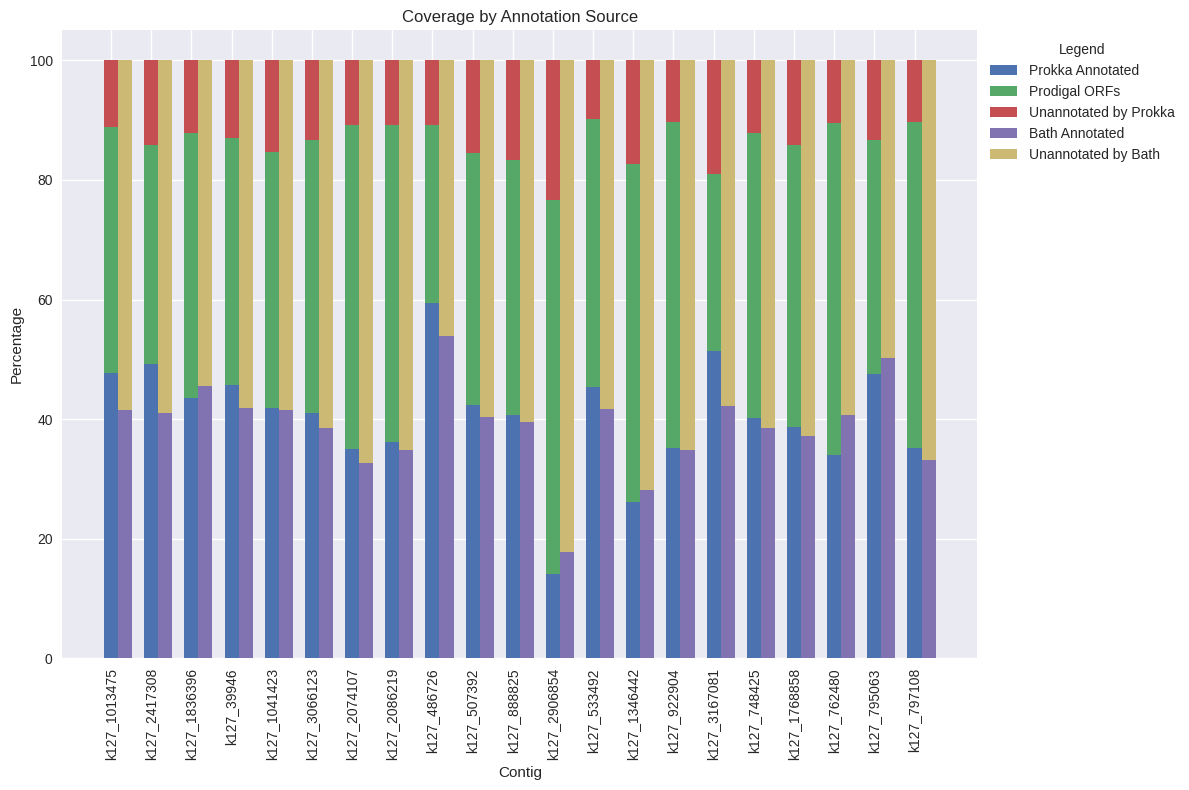

In [ ]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 8))
n_contigs = len(contigs_info)
index = range(n_contigs)
bar_width = 0.35

bar2 = ax.bar(index, contigs_info['percent_covered_prokka'], bar_width, label='Prokka Annotated')
bar1 = ax.bar(index, contigs_info['percent_covered_prodigal'], bar_width, bottom=contigs_info['percent_covered_prokka'], label='Prodigal ORFs')
bar3 = ax.bar(index, contigs_info['percent_uncovered_prokka'], bar_width, bottom=contigs_info['percent_covered_prodigal']+contigs_info['percent_covered_prokka'], label='Unannotated by Prokka')

bar4 = ax.bar([p + bar_width for p in index], contigs_info['percent_covered_bath'], bar_width, label='Bath Annotated')
bar5 = ax.bar([p + bar_width for p in index], contigs_info['percent_uncovered_bath'], bar_width, bottom=contigs_info['percent_covered_bath'], label='Unannotated by Bath')

ax.set_xlabel('Contig')
ax.set_ylabel('Percentage')
ax.set_title('Coverage by Annotation Source')
indices = range(n_contigs)
ax.set_xticks(indices)
ax.set_xticklabels(contigs_info['seq_id'], rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Legend")
plt.tight_layout()
plt.show()

#### Venn diagram of region based overlaps

In [ ]:
def transform_file_to_dataframe(file_path):
    transformed_rows = []

    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            fields = line.strip().split(';')
            if len(fields) == 3:
                new_row1 = [fields[0], fields[1]]
                new_row2 = [fields[0], fields[2]]
                transformed_rows.append(new_row1)
                transformed_rows.append(new_row2)
            else:
                transformed_rows.append(fields)
    df = pd.DataFrame(transformed_rows, columns=['BATH', 'Prokka']).replace("\n",np.nan).dropna()

    return df

In [ ]:
file_path = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Combined Files/overlap_prokka_bath_combined.bed'
overlaps = transform_file_to_dataframe(file_path)

In [ ]:
overlaps.to_excel("test.xlsx")

In [ ]:
def determine_label(row):
    if row['Prokka'].endswith('ab initio prediction:Prodigal:002006'):
        return "BATH and Prokka Unannotated"
    else:
        return "BATH and Prokka Annotated"

overlaps['label'] = overlaps.apply(determine_label, axis=1)

In [ ]:
overlaps

,BATH,Prokka,label
0,k127_922904\t1\t738\tISBf5\t+\t0,k127_922904\t7\t861\tCKDIDOFJ_01216\t+\tab ini...,BATH and Prokka Annotated
1,k127_922904\t6189\t6455\tQ47149\t+\t0,k127_922904\t6189\t6464\tCKDIDOFJ_01219\t+\tab...,BATH and Prokka Annotated
2,k127_922904\t9119\t11146\tMF_01588\t+\t0,k127_922904\t9143\t11155\tCKDIDOFJ_01224\t+\ta...,BATH and Prokka Annotated
3,k127_922904\t15889\t18507\tMF_00036_B\t+\t0,k127_922904\t15886\t18519\tCKDIDOFJ_01229\t+\t...,BATH and Prokka Annotated
4,k127_922904\t18858\t19337\tMF_00484\t+\t0,k127_922904\t18846\t19685\tCKDIDOFJ_01230\t+\t...,BATH and Prokka Annotated
...,...,...,...
502,k127_1041423\t78466\t78633\tMF_00236\t+\t0,k127_1041423\t78430\t78684\tCKDIDOFJ_00361\t+\...,BATH and Prokka Annotated
503,k127_1041423\t78707\t79399\tMF_00902\t+\t0,k127_1041423\t78707\t79558\tCKDIDOFJ_00362\t+\...,BATH and Prokka Annotated
504,k127_1041423\t83340\t84335\tMF_01582\t+\t0,k127_1041423\t83316\t84551\tCKDIDOFJ_00367\t+\...,BATH and Prokka Annotated
505,k127_1041423\t84738\t85082\tMF_01394\t+\t0,k127_1041423\t84705\t85085\tCKDIDOFJ_00368\t+\...,BATH and Prokka Annotated


In [ ]:
file_path = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Combined Files/unique_to_bath_combined.bed'
with open(file_path, 'r') as file:
    lines = [line.strip() for line in file.readlines() if line.strip()]
unique_to_bath = pd.DataFrame(lines, columns=['BATH']).replace("\n",np.nan).dropna()
unique_to_bath['Prokka'] = np.nan
unique_to_bath['label'] = 'BATH'

In [ ]:
file_path3 = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/BED/Combined Files/unique_to_prokka_combined.bed'
with open(file_path3, 'r') as file:
    lines = [line.strip() for line in file.readlines() if line.strip()]
unique_to_prokka = pd.DataFrame(lines, columns=['Prokka']).replace("\n",np.nan).dropna()
unique_to_prokka['BATH'] = np.nan

def determine_label2(row):
    if row['Prokka'].endswith('ab initio prediction:Prodigal:002006'):
        return "Prokka Unannotated"
    else:
        return "Prokka Annotated"

unique_to_prokka['label'] = unique_to_prokka.apply(determine_label2, axis=1)

In [ ]:
venn_data = pd.concat([unique_to_prokka,unique_to_bath,overlaps])

In [ ]:
venn_data.to_excel("/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/Alignment_Overlaps_Unique_Bedmap_Output.xlsx",index=False)

In [ ]:
venn_data['label'].value_counts()

label
Prokka Unannotated             423
BATH and Prokka Annotated      414
BATH and Prokka Unannotated     74
Prokka Annotated                18
BATH                            18
Name: count, dtype: int64

In [ ]:
venn_data[venn_data['label'] == "Prokka Unannotated"]

,Prokka,BATH,label
0,k127_922904\t1075\t5760\tCKDIDOFJ_01217\t+\tab...,NaN,Prokka Unannotated
1,k127_922904\t6844\t7872\tCKDIDOFJ_01221\t+\tab...,NaN,Prokka Unannotated
2,k127_922904\t7925\t8473\tCKDIDOFJ_01222\t+\tab...,NaN,Prokka Unannotated
3,k127_922904\t8452\t9081\tCKDIDOFJ_01223\t+\tab...,NaN,Prokka Unannotated
4,k127_922904\t11548\t13251\tCKDIDOFJ_01225\t+\t...,NaN,Prokka Unannotated
...,...,...,...
436,k127_1041423\t66604\t66714\tCKDIDOFJ_00349\t+\...,NaN,Prokka Unannotated
437,k127_1041423\t79618\t80436\tCKDIDOFJ_00363\t+\...,NaN,Prokka Unannotated
438,k127_1041423\t80690\t81955\tCKDIDOFJ_00364\t+\...,NaN,Prokka Unannotated
439,k127_1041423\t81996\t82505\tCKDIDOFJ_00365\t+\...,NaN,Prokka Unannotated


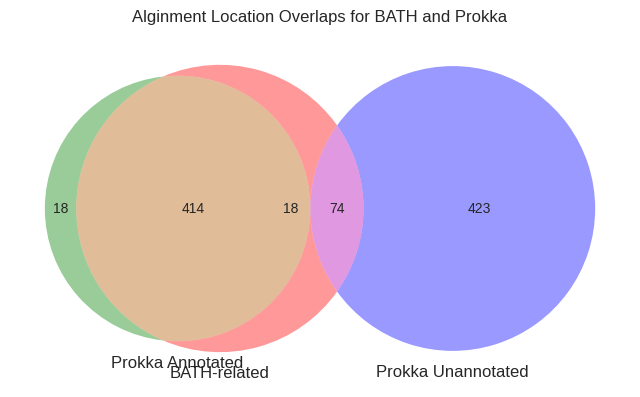

In [ ]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Assuming venn_data is your DataFrame
venn_counts = {
    '100': venn_data[venn_data['label'] == "BATH"].shape[0],  # Only BATH
    '010': venn_data[venn_data['label'] == "Prokka Annotated"].shape[0],  # Only Prokka Annotated
    '001': venn_data[venn_data['label'] == "Prokka Unannotated"].shape[0],  # Only Prokka Unannotated
    '110': venn_data[venn_data['label'] == "BATH and Prokka Annotated"].shape[0],  # Intersection BATH and Prokka Annotated
    '101': venn_data[venn_data['label'] == "BATH and Prokka Unannotated"].shape[0],  # Intersection BATH and Prokka Unannotated
    '011': 0,  # Intersection of Prokka Annotated and Prokka Unannotated (not given)
    '111': 0   # Intersection of all three (not applicable)
}

venn3(subsets=venn_counts, set_labels=('BATH-related', 'Prokka Annotated', 'Prokka Unannotated'))
plt.title("Alginment Location Overlaps for BATH and Prokka")
plt.show()


### Checking frameshifts for every group

In [ ]:
bath_data = venn_data[(venn_data['label'] != "Prokka Annotated") & (venn_data['label'] != "Prokka Unannotated")]

In [ ]:
shifts = []
for index, rows in bath_data.iterrows():
  shifts.append(rows['BATH'].split("\t")[-1])

In [ ]:
frameshifts = pd.DataFrame()
frameshifts['label'] = bath_data['label']
frameshifts['shifts'] = shifts

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 87.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 90.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 43.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


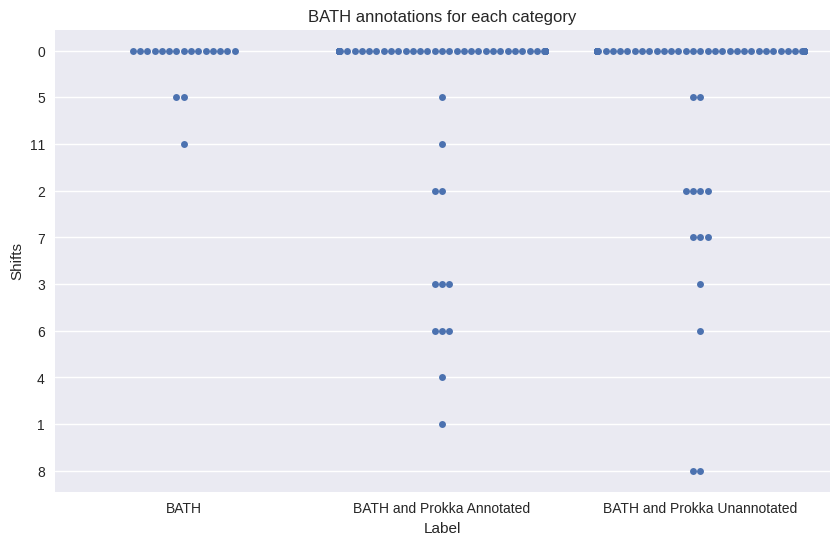

In [ ]:
plt.figure(figsize=(10, 6))
swarmplot = sns.swarmplot(x='label', y='shifts', data=frameshifts)
plt.title('BATH annotations for each category')
plt.xlabel('Label')
plt.ylabel('Shifts')
plt.show()

In [ ]:
#You need to find the areas annotated by BATH in regions that only prodigal annotates
#You also need to find BATH individual areas

In [ ]:
#You also need to quantify it somehow